# Train CNN With Transfer Learning on Chest CT Scans Dataset

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

2024-12-16 06:50:19.183530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Chest CT Scans Dataset
train_data = "Chest CT Scans Dataset/train"
test_data = "Chest CT Scans Dataset/test"
validation_data = "Chest CT Scans Dataset/valid"

normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

In [3]:
# Set the Image Size for Resizing
image_size = (350, 350)

# Initialize the Image Data Generators for Training and Testing
print("Read Training Images From: ", train_data)
print("Read Validation Images From: ", validation_data)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Batch Size
batch_size = 8

# Data Generators
training_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Read Training Images From:  Chest CT Scans Dataset/train
Read Validation Images From:  Chest CT Scans Dataset/valid
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [4]:
# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', verbose=1, save_best_only=True)

In [5]:
# Define the number of output classes
output_size = 4

# Pretrained Model
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
pretrained_model.trainable = False  # Initially freeze layers

# Create a new model with the pre-trained base and additional layers for classification
# Build the Model
model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(output_size, activation='softmax')
])

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


2024-12-16 06:51:29.459501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pretrained model used:
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 174, 174, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 174, 174, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                   

 block4_sepconv1_bn (BatchNorma  (None, 43, 43, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 43, 43, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 43, 43, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 43, 43, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 22, 22, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 22, 22, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 22, 22, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 22, 22, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 22, 22, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 22, 22, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 22, 22, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 22, 22, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 22, 22, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 22, 22, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [6]:
# Train Model
# Initial Training (With Frozen Layers)
history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
    epochs=10,  # Shorter initial training
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[learning_rate_reduction, early_stopping, checkpointer]
)

print("Training accuracy =", history.history['accuracy'][-1])
print("Testing accuracy =", history.history['val_accuracy'][-1])

Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.5334
Epoch 1: val_loss improved from inf to 0.95225, saving model to best_model.hdf5
77/77 [==============================] - 117s 1s/step - loss: 1.0675 - accuracy: 0.5334 - val_loss: 0.9522 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.6476
Epoch 2: val_loss improved from 0.95225 to 0.87971, saving model to best_model.hdf5
77/77 [==============================] - 112s 1s/step - loss: 0.8203 - accuracy: 0.6476 - val_loss: 0.8797 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7145
Epoch 3: val_loss improved from 0.87971 to 0.87616, saving model to best_model.hdf5
77/77 [==============================] - 390s 5s/step - loss: 0.6852 - accuracy: 0.7145 - val_loss: 0.8762 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 4/10
77/77 [=======================

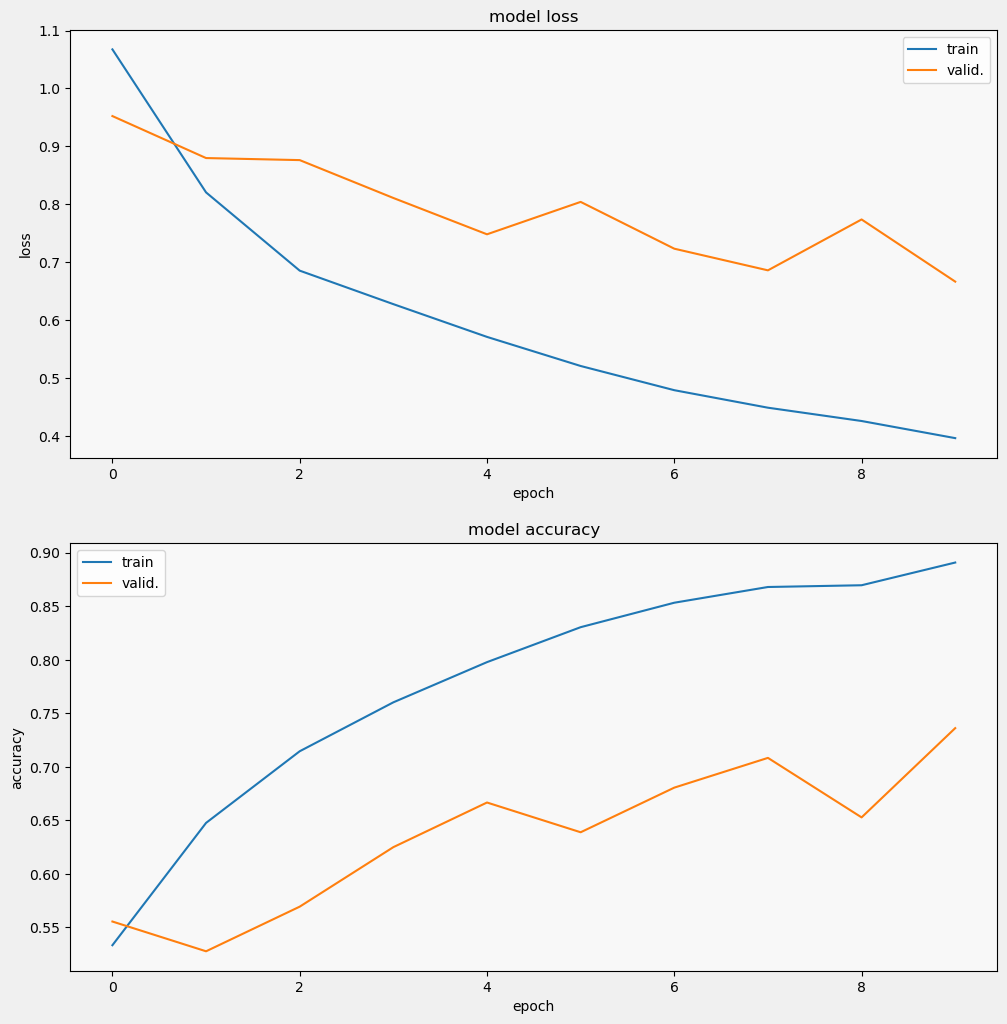

In [7]:
# Plot Model Loss and Accuracy

# Function to display training curves for loss and accuracy
def plot_accuracy_loss(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
plot_accuracy_loss(history.history['loss'], history.history['val_loss'], 'loss', 211)
plot_accuracy_loss(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [8]:
# Fine-tune the Model
pretrained_model.trainable = True  # Unfreeze layers

# Recompile the Model with a Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning Training
fine_tune_history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[learning_rate_reduction, early_stopping, checkpointer]
)

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 1.2008 - accuracy: 0.5057
Epoch 1: val_loss did not improve from 0.66619
77/77 [==============================] - 441s 6s/step - loss: 1.2008 - accuracy: 0.5057 - val_loss: 0.9685 - val_accuracy: 0.6111 - lr: 1.0000e-05
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.7325
Epoch 2: val_loss did not improve from 0.66619
77/77 [==============================] - 643s 8s/step - loss: 0.7341 - accuracy: 0.7325 - val_loss: 1.0236 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8320
Epoch 3: val_loss did not improve from 0.66619
77/77 [==============================] - 476s 6s/step - loss: 0.5312 - accuracy: 0.8320 - val_loss: 0.9921 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8695
Epoch 4: val_loss did not improve from 0.6

Epoch 26: early stopping


In [13]:
print("Training accuracy =", fine_tune_history.history['accuracy'][-1])
print("Testing accuracy =", fine_tune_history.history['val_accuracy'][-1])

Training accuracy = 0.9983686804771423
Testing accuracy = 0.9027777910232544


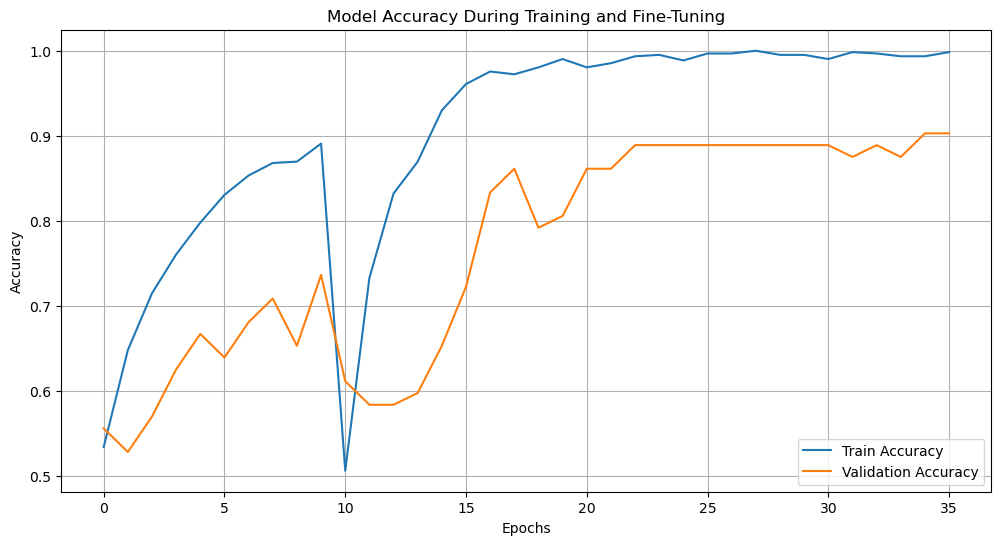

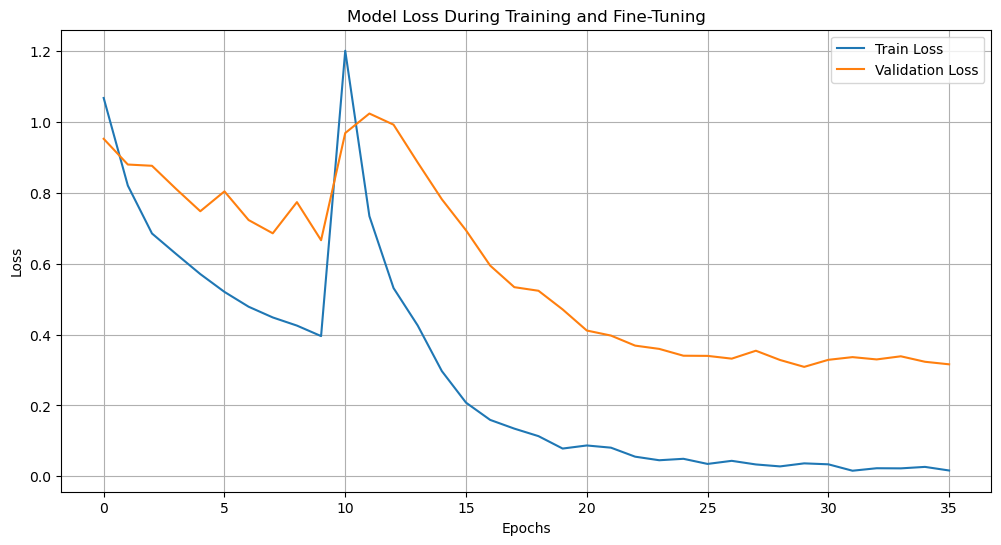

In [14]:
# Plot Model Loss and Accuracy

# Combine histories from initial training and fine-tuning
history_combined = {
    'accuracy': history.history['accuracy'] + fine_tune_history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
    'loss': history.history['loss'] + fine_tune_history.history['loss'],
    'val_loss': history.history['val_loss'] + fine_tune_history.history['val_loss']
}

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_combined['accuracy'], label='Train Accuracy')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training and Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_combined['loss'], label='Train Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training and Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Ensure order is preserved for evaluation
)

# Predict on the test set
test_steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = test_generator.classes

# Get the class labels (mapping indices to class names)
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Found 315 images belonging to 4 classes.
40/40 [==============================] - 58s 1s/step
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.88      0.88      0.88       120
   large.cell.carcinoma       0.85      0.88      0.87        51
                 normal       1.00      0.96      0.98        54
squamous.cell.carcinoma       0.91      0.91      0.91        90

               accuracy                           0.90       315
              macro avg       0.91      0.91      0.91       315
           weighted avg       0.91      0.90      0.91       315



In [16]:
pretrained_model.save("Models/Transfer Learning_Chest CT Scans Dataset.h5")

## Making Predictions on Chest CT Scans Dataset

In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [18]:
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

1/1 [==============================] - 1s 521ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


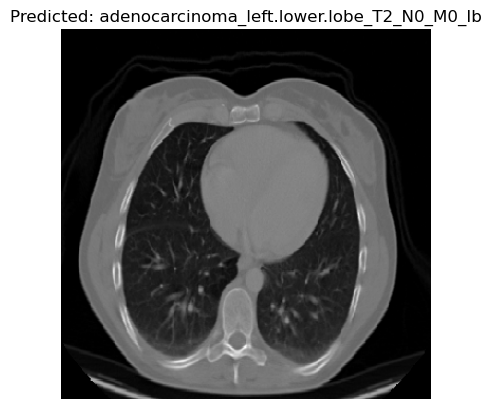

In [23]:
# Load, preprocess, and predict the class of an image
img_path = 'Chest CT Scans Dataset/test/adenocarcinoma/000108 (3).png'
img = load_and_preprocess_image(img_path, image_size)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
class_labels = list(training_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=image_size))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 425ms/step
The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


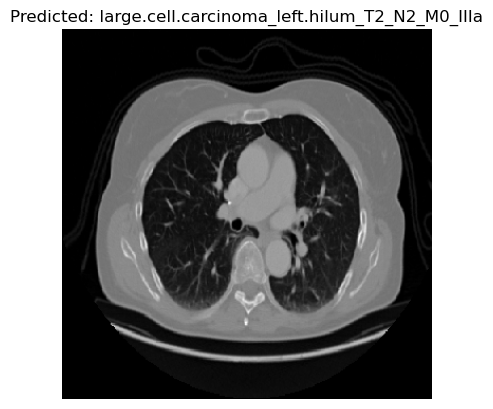

In [24]:
# Repeat the process for additional images
img_path = 'Chest CT Scans Dataset/test/large.cell.carcinoma/000110.png'
img = load_and_preprocess_image(img_path, image_size)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=image_size))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 389ms/step
The image belongs to class: normal


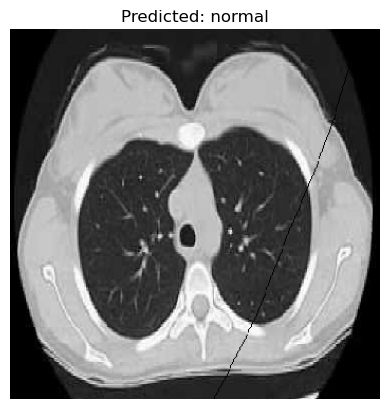

In [25]:
img_path = 'Chest CT Scans Dataset/test/normal/10 (2).png'
img = load_and_preprocess_image(img_path, image_size)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=image_size))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 458ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


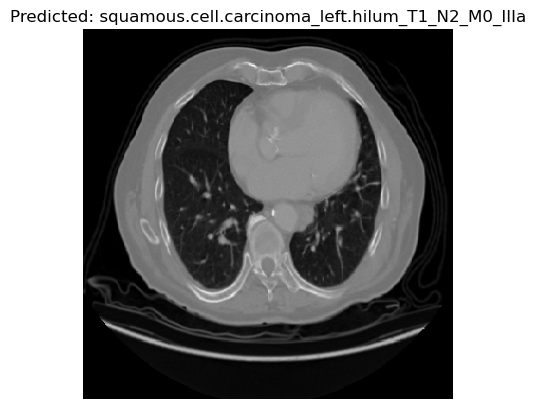

In [26]:
img_path = 'Chest CT Scans Dataset/test/squamous.cell.carcinoma/000111.png'
img = load_and_preprocess_image(img_path, image_size)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=image_size))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()